In [1]:
import logging
import sys
from pathlib import Path


logging.basicConfig(
    level=logging.DEBUG,
    format="%(levelname)s: %(message)s",
    force=True,
)

# Add the src directory to the Python path
sys.path.append(str(Path.cwd().parent.parent))

In [2]:
from pprint import pprint

from pymoo.optimize import minimize

from src.constants import SEED
from src.nas.nas_params import NasParams
from src.nas.plot import hist_accuracies


DEBUG: matplotlib data path: /home/nur/Projects/vut-ip1-nn-quantization/venv/lib/python3.13/site-packages/matplotlib/mpl-data
DEBUG: CONFIGDIR=/home/nur/.config/matplotlib
DEBUG: interactive is False
DEBUG: platform is linux
DEBUG: CACHEDIR=/home/nur/.cache/matplotlib
DEBUG: Using fontManager instance from /home/nur/.cache/matplotlib/fontlist-v390.json


In [3]:
from src.nas.chromosome import ChromosomeConfig
from src.nas.cnn_chromosome import CNNChromosome

ch_cfg = ChromosomeConfig(CNNChromosome)
pprint(ch_cfg.get_size())
pprint(ch_cfg.get_bounds())

35
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([7, 3, 4, 1, 1, 7, 4, 1, 1, 7, 4, 1, 1, 7, 4, 1, 1, 7, 2, 4, 7, 4,
       7, 4, 7, 7, 3, 3, 2, 3, 0, 0, 0, 0, 0]))


In [4]:
from src.datasets.cifar10_dataset import CIFAR10Dataset, MiniCIFAR10Dataset
from src.datasets.mnist_dataset import MiniMNISTDataset
from src.nas.cnn_nas_problem import CnnNasProblem


CnnDatasetClass = MiniMNISTDataset
cnn_nas_params = NasParams(
    batch_size=64,
    epochs=10,
    patience=5,
    amount_of_evaluations=1,
    population_size=20,
    population_offspring_count=8,
    algorithm_generations=1,
    population_store_file=CnnDatasetClass.__name__ + "_population.csv",
)
cnn_problem = CnnNasProblem(cnn_nas_params, CnnDatasetClass)

cnn_problem.get_min_complexity(), cnn_problem.get_max_complexity()

(11744.0, 23023506.0)

In [42]:
ch_cfg.get_bounds()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]),
 array([7, 2, 2, 1, 1, 7, 2, 1, 1, 7, 2, 1, 1, 7, 2, 3, 7, 3, 7, 3, 7, 3,
        3, 2, 3, 0, 0, 0, 6, 3]))

In [43]:
import numpy as np
from src.models.cnn import CNN

x = np.array([0, 1, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
cnn_ch = ch_cfg.decode(x)
pprint(cnn_ch)

CNNChromosome(in_bitwidth=1,
              conv_layers=2,
              conv_channels1=32,
              conv_stride1=1,
              conv_pooling_size1=2,
              conv_compression_bitwidth1=1,
              conv_channels2=16,
              conv_stride2=1,
              conv_pooling_size2=2,
              conv_compression_bitwidth2=1,
              conv_channels3=16,
              conv_stride3=1,
              conv_pooling_size3=1,
              conv_compression_bitwidth3=1,
              fc_layers=1,
              fc_height1=16,
              fc_bitwidth1=1,
              fc_height2=16,
              fc_bitwidth2=1,
              fc_height3=16,
              fc_bitwidth3=1,
              conv_compression=<NNParamsCompMode.BINARY: 'binary'>,
              fc_compression=<NNParamsCompMode.BINARY: 'binary'>,
              dropout=0.0,
              activation=<Activation.NONE: 'none'>,
              activation_qmode=<QMode.DET: 'det'>,
              activation_reste_o=1.5,
       

In [44]:
cnn_params = cnn_problem.get_nn_params(cnn_ch)
CNN(cnn_params)

CNN(
  (quantize_input): Quantize()
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2dBinary(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Identity()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2dBinary(32, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Identity()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc_layers): Sequential(
    (0): LinearBinary(in_features=400, out_features=16, bias=False)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Identity()
    (3): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [45]:
from src.models.eval import NNArchitectureEvaluator

evaluator = NNArchitectureEvaluator(cnn_params.train)

evaluator.evaluate_complexity(cnn_params)

41474.0

In [46]:
evaluator.evaluate_accuracy(cnn_params)

DEBUG: Train Epoch:  1 [ 800/3200] Loss: 2.2723
DEBUG: Train Epoch:  1 [1600/3200] Loss: 2.0927
DEBUG: Train Epoch:  1 [2400/3200] Loss: 1.8355
DEBUG: Train Epoch:  1 [3200/3200] Loss: 1.7775
DEBUG: Test set: Average loss: 1.7832, Accuracy: 353/800 (44.12%)
DEBUG: Train Epoch:  2 [ 800/3200] Loss: 1.7453
DEBUG: Train Epoch:  2 [1600/3200] Loss: 1.4489
DEBUG: Train Epoch:  2 [2400/3200] Loss: 1.5189
DEBUG: Train Epoch:  2 [3200/3200] Loss: 1.6506
DEBUG: Test set: Average loss: 1.5259, Accuracy: 508/800 (63.50%)
DEBUG: Train Epoch:  3 [ 800/3200] Loss: 1.3944
DEBUG: Train Epoch:  3 [1600/3200] Loss: 1.5740
DEBUG: Train Epoch:  3 [2400/3200] Loss: 1.5519
DEBUG: Train Epoch:  3 [3200/3200] Loss: 1.5266
DEBUG: Test set: Average loss: 1.3440, Accuracy: 589/800 (73.62%)
DEBUG: Train Epoch:  4 [ 800/3200] Loss: 1.3247
DEBUG: Train Epoch:  4 [1600/3200] Loss: 1.3867
DEBUG: Train Epoch:  4 [2400/3200] Loss: 1.1612
DEBUG: Train Epoch:  4 [3200/3200] Loss: 1.3531
DEBUG: Test set: Average loss: 1.2

{'max': 92.0,
 'mean': np.float64(87.825),
 'std': np.float64(2.615578329930113),
 'accuracies': [88.25, 86.875, 92.0, 83.875, 88.125],
 'best_model': CNN(
   (quantize_input): Quantize()
   (conv_layers): ModuleList(
     (0): Sequential(
       (0): Conv2dBinary(1, 32, kernel_size=(3, 3), stride=(1, 1))
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): Identity()
       (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     )
     (1): Sequential(
       (0): Conv2dBinary(32, 16, kernel_size=(3, 3), stride=(1, 1))
       (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): Identity()
       (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     )
   )
   (fc_layers): Sequential(
     (0): LinearBinary(in_features=400, out_features=16, bias=False)
     (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [9]:
algorithm = cnn_nas_params.get_algorithm()
termination = cnn_nas_params.get_termination()

res = minimize(cnn_problem, algorithm, verbose=True, seed=SEED, termination=termination)

if cnn_nas_params.population_store_file is not None:
    cnn_nas_params.store_population(res, cnn_nas_params.population_store_file)

print(f"Solutions: {res.X}")
print(f"Objectives: {res.F}")

INFO: Population file `MiniMNISTDataset_population.csv` is empty. Using random sampling
DEBUG: Evaluating CNNParams(conv=ConvParams(in_channels=1, in_dimensions=28, in_bitwidth=6, out_height=10, layers=[ConvLayerParams(channels=32, kernel_size=3, stride=2, padding=0, dilation=1, groups=1, bias=True, pooling_kernel_size=1), ConvLayerParams(channels=24, kernel_size=3, stride=2, padding=0, dilation=1, groups=1, bias=True, pooling_kernel_size=1), ConvLayerParams(channels=24, kernel_size=3, stride=1, padding=0, dilation=1, groups=1, bias=True, pooling_kernel_size=2)], compression=<NNParamsCompMode.NBITS: 'nbits'>, reste_threshold=3.0, reste_o=1.5, activation=ActivationParams(activation=<Activation.BINARIZE_RESTE: 'binary_ReSTE'>, binary_qmode=<QMode.DET: 'det'>, reste_o=1.5, reste_threshold=3.0), dropout_rate=0.2), fc=FCParams(layers=[FCLayerParams(height=32, compression=<NNParamsCompMode.NBITS: 'nbits'>, bitwidth=3), FCLayerParams(height=64, compression=<NNParamsCompMode.NBITS: 'nbits'>, b

KeyboardInterrupt: 

In [14]:
df = cnn_problem.result_as_df(res)
df

,Accuracy,Complexity,conv_in_channels,conv_in_dimensions,conv_in_bitwidth,conv_out_height,conv_layers,conv_activation,conv_reste_threshold,conv_reste_o,...,fc_layers,fc_activation,fc_qmode,fc_dropout_rate,train_DatasetCls,train_epochs,train_learning_rate,train_weight_decay,train_early_stop_patience,Chromosome
0,93.25,229672.0,1,28,1,10,"[{'channels': 32, 'kernel_size': 3, 'stride': ...",Activation.RELU,1.5,1.5,...,"[{'height': 784, 'weight_qmode': WeightQuantMo...","{'activation': Activation.RELU, 'binary_...",QMode.DET,0.0,<class 'src.datasets.mnist_dataset.MiniMNISTDa...,3,0.005,0.001,5,"[0, 2, 2, 1, 1, 1, 0, 0, 2, 0, 0, 2, 2, 2, 2, ..."


In [15]:
pprint(cnn_problem.get_nn_params(RawCNNChromosome(res.X[0]).parse()))

CNNParams(conv=ConvParams(in_channels=1,
                          in_dimensions=28,
                          in_bitwidth=1,
                          out_height=10,
                          layers=[ConvLayerParams(channels=32,
                                                  kernel_size=3,
                                                  stride=2,
                                                  padding=0,
                                                  dilation=1,
                                                  groups=1,
                                                  bias=True,
                                                  pooling_kernel_size=2),
                                  ConvLayerParams(channels=24,
                                                  kernel_size=3,
                                                  stride=1,
                                                  padding=0,
                                                  dilation=1,
                

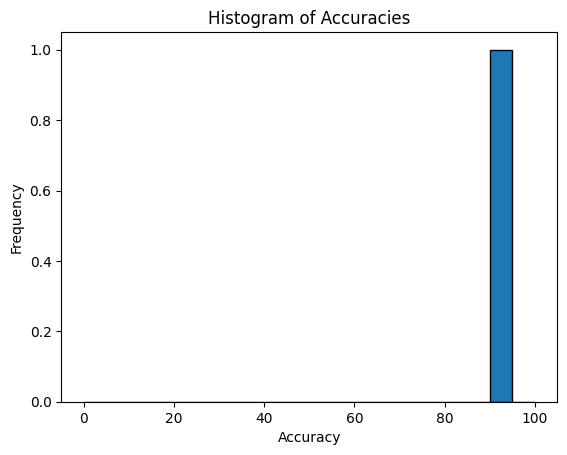

In [16]:
fig = hist_accuracies(df["Accuracy"])

/home/nur/Projects/vut-ip1-nn-quantization/src/nas/plot.py:46: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(


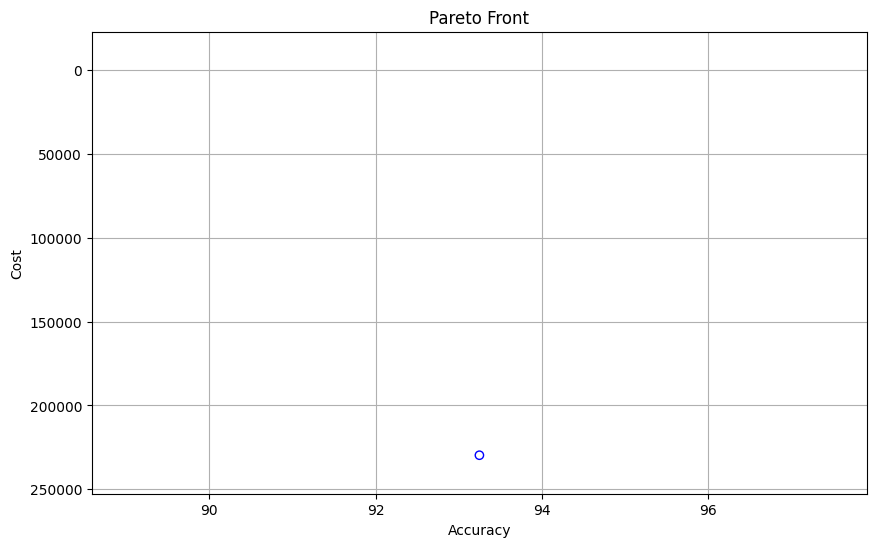

In [17]:
from src.nas import plot

fig = plot.plot_pareto_front(df["Accuracy"], df["Complexity"])

In [13]:
pprint(RawCNNChromosome(df.iloc[2]["Chromosome"]).parse())

df.iloc[2]["Accuracy"]

IndexError: single positional indexer is out-of-bounds

In [ ]:
pprint(RawCNNChromosome(df.iloc[4]["Chromosome"]).parse())

df.iloc[4]["Accuracy"]

CNNChromosome(in_bitwidth=5,
              conv_layers=2,
              conv_channels1=32,
              conv_stride1=2,
              conv_pooling_size1=1,
              conv_channels2=24,
              conv_stride2=2,
              conv_pooling_size2=1,
              conv_channels3=32,
              conv_stride3=2,
              conv_pooling_size3=1,
              fc_layers=1,
              fc_height1=32,
              fc_bitwidth1=8,
              fc_height2=64,
              fc_bitwidth2=7,
              fc_height3=32,
              fc_bitwidth3=5,
              dropout=0.0,
              activation=<Activation.BINARIZE_RESTE: 'binary_ReSTE'>,
              reste_o=3.0,
              reste_threshold=1.5,
              quatization_mode=<QMode.DET: 'det'>,
              binarization_mode=<QMode.DET: 'det'>,
              learning_rate=0.002,
              weight_decay=0.01)


np.float64(43.125)